## Concentriq® Embeddings with Region of Interest targeting

In this notebook, we will illustrate how to:
- Request and download image thumbnails
- Define region(s) of interest over which to request embeddings
- Visualize the resulting embedded patches

In [1]:
import yaml
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np

from utils.client import ClientWrapper as Client

MODEL = "1aurent/swin_tiny_patch4_window7_224.CTransPath"
PATCH_SIZE = 224
MPP = 1

with open('creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

# To use CPU instead of GPU, set `device` parameter to `"cpu"`
ce_api_client = Client(**creds, device='cpu')
ce_api_client

# Fetch a thumbnail of a slide
Concentriq embeddings will produce thumbnail images of slides at 7 microns per pixel. We can then use these to select regions of interest (here we'll focus on tissue) to be embedded. 

In [2]:
image_id = 6453
image_ids = [image_id] # A sinlge image from the IMPRESS Dataset
ticket_id = ce_api_client.thumbnail_images(ids=image_ids)

In [3]:
print(ticket_id)

2dd9dfa0-0e08-460c-8798-eecbae90f817


In [4]:
thumbnails = ce_api_client.get_thumbnails(ticket_id, load_thumbnails=True, polling_interval_seconds=10)

status='completed' progress=1.0 finished=1 failed=0 queued=0 processing=0


# Segment Tissue using the thumbnail

Here we'll use a simple thresholding method (Otsu) to identify tissue regions.

In [5]:
def simple_tissue_otsu(thumbnail, thumbnail_mpp=7, embedding_mpp=2, patch_size=224):
    """
    Simple tissue detection using Otsu thresholding
    
    Args:
    thumbnail: np.array
        Thumbnail image
    thumbnail_mpp: float
        Microns per pixel of the thumbnail. The default is 7, which is what Concentriq Embeddings supplies.
    embedding_mpp: float
        Microns per pixel of the embedding
    patch_size: int
        Patch size in pixels -- This is model-dependent, default is 224. 
        
    Returns:
    regions: list
        List of dictionaries containing x, y, width, and height of the detected tissue regions
    """
    # convert to gray scale
    img = cv2.cvtColor(thumbnail, cv2.COLOR_BGR2GRAY)
    otsu_threshold, res = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
    )
    print("Obtained threshold: ", otsu_threshold)

    # remove noise
    raw_mask = (res==0).astype(np.uint8)
    noise_removal_kernel = np.ones((3, 3), np.uint8)
    noise_mask = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, noise_removal_kernel)

    # fill small gaps
    fill_gaps_kernel = np.ones((100, 100), np.uint8)
    filled_mask = cv2.morphologyEx(noise_mask, cv2.MORPH_CLOSE, fill_gaps_kernel)

    thumbnail_patch_size = round(patch_size * embedding_mpp / thumbnail_mpp)
    grid_x = np.arange(0, thumbnail.shape[1] // thumbnail_patch_size).astype(int)
    grid_y = np.arange(0, thumbnail.shape[0] // thumbnail_patch_size).astype(int)
    regions = []
    ratio = patch_size * embedding_mpp / thumbnail_mpp
    for x in grid_x:
        for y in grid_y:
            x_start = round(x * ratio)
            y_start = round(y * ratio)
            x_end = round(x_start + thumbnail_patch_size)
            y_end = round(y_start + thumbnail_patch_size)
            patch = filled_mask[y_start:y_end, x_start:x_end].sum()
            if np.sum(patch) > 0:
                cv2.rectangle(thumbnail, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)
                regions.append({
                    "x": int(x_start),
                    "y": int(y_start),
                    "width": int(thumbnail_patch_size),
                    "height": int(thumbnail_patch_size),
                })
    plt.imshow(thumbnail)
    plt.axis("off")
    plt.show()
    return regions

Obtained threshold:  198.0


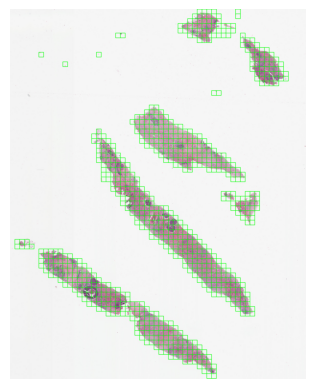

Segmented tissue into 824 bounding box regions of interest


In [6]:
thumbnail_img = thumbnails["thumbnails"][0]["thumbnail"].copy()
bbs = simple_tissue_otsu(thumbnail_img, patch_size=PATCH_SIZE, embedding_mpp=MPP)
print(f"Segmented tissue into {len(bbs)} bounding box regions of interest")

# Submit a job containing regions of interest to be embedded

In [7]:
ticket_id = ce_api_client.embed_roi(image_id=image_id, regions=bbs, mpp=MPP, model=MODEL)
print(ticket_id)

374e6951-c2d1-4115-b676-ca015d9cd147


In [9]:
embeddings = ce_api_client.get_embeddings(ticket_id, polling_interval_seconds=30)

In [10]:
# Check that we used the correct patch size for the model
assert embeddings["images"][0]["patch_size"] == PATCH_SIZE

# Visualize the resulting embedded patches
Here we'll use the Y_X grid locations of the embedings in conjunction with the embedding mpp that we requested to map the embedded patches onto the thumbnail and confirm that the locations are what we requested.

In [11]:
emb_keys = embeddings["images"][0]["embedding"].keys()
emb_locs = np.array([[int(coord) for coord in k.split("_")] for k in emb_keys])

32


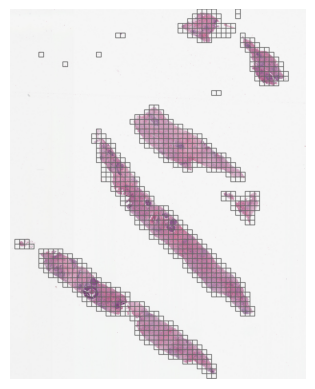

In [12]:
thumbnail = thumbnail_img.copy()
mpp = embeddings["images"][0]["mpp"]
patch_size = embeddings["images"][0]["patch_size"]
thumbnail_mpp = 7
thumbnail_patch_size = round(patch_size * mpp / thumbnail_mpp)
mircons_per_patch = patch_size * mpp
print(thumbnail_patch_size)
w, h = thumbnail_patch_size, thumbnail_patch_size
for y, x in emb_locs:
    x_thumb = round(x * mircons_per_patch / thumbnail_mpp)
    y_thumb = round(y * mircons_per_patch / thumbnail_mpp)
    cv2.rectangle(thumbnail, (x_thumb, y_thumb), (x_thumb+w, y_thumb+h), (100, 100, 100), 4)
plt.imshow(thumbnail)
plt.axis("off")
imageio.imwrite(f"{image_id}_{MODEL.split('/')[-1]}_{mpp}_ROI_thumbnail.png", thumbnail)